In [1]:
%matplotlib ipympl
import numpy as np
import sys

# setting path for mask_utils package
sys.path.append('..')

from mask_utils.code_utils import next_prime, ura_mura
from mask_utils.imaging_utils import  decode, decode_var, generate_bulk, get_openfraction,  get_skysign, get_skycoords, get_detimage_edges, get_detimage
from mask_utils.fits_utils import read_mask_bulk, write_mask_fits, read_fits_events
from mask_utils.image_utils import upscale, pad_array#, fshift, ferosion
from scipy.signal import convolve
from scipy.ndimage import center_of_mass
from scipy.ndimage import shift as ndshift
from scipy.ndimage import gaussian_filter as gaussian_filter


import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
mask_file = "F:/CodedMasks/mask_050_1040x17/mask_050_1040x17_20250725.fits"

In [3]:
mask, hdmask = read_mask_bulk(mask_file, 2, header_out=True, verbose=False)
rmatrix = read_mask_bulk(mask_file, 3, verbose=False)
bulk = read_mask_bulk(mask_file, 4, verbose=False)

In [4]:
#Gets mask information and define X, Y vectors (centers and edges)
ELXDIM = hdmask['ELXDIM'] 
ELYDIM = hdmask['ELYDIM'] 
ELXN   = hdmask['ELXN'] 
ELYN   = hdmask['ELYN']
MTHICK = 0.150
focal  = 202.9 + MTHICK

In [5]:
def fshift(arr, lagx, lagy):
    """
    Shifts a 2D array (casted to float) with fractional shifts using SciPy.
    
    Note: SciPy's shift convention is (y, x), but our images are already in the right shape
    """
    return ndshift(arr, (lagx, lagy), 'float', order=1, prefilter=True, mode='grid-constant', cval=0.0)

In [6]:
def ferosion( arr,step,cut):
    """
    2D matrix erosion for simulating finite thickness effect in shadow projections.
    It takes a mask array and "thins" the mask elements across the columns' direction.
    """
    # number of bins to cut
    ncuts = int(cut / step)# + int(np.sign(cut))
    print('ncuts', ncuts)
    print('cut', cut)
    
    arr_mask = (arr > 0) & (fshift(arr, ncuts , 0 ) > 0)
    cutted = arr * arr_mask if ncuts else arr

    # array indexes to be fractionally reduced:
    #   - the bin with the decimal values is the one
    #     to the left or right wrt the cutted bins
    erosion_value =  abs(cut / step - ncuts)
    print('erosion value', erosion_value)
    
    cutted_mask = (
        np.array((cutted > 0), dtype=int) - np.array((fshift(cutted, int(np.sign(cut)), 0) > 0), dtype=int)
    )
    border = (cutted_mask > 0)
    return cutted * (1.0 - border * erosion_value)


<img src="new_mask_erosion_screenshot.png"> </img>

In [7]:
def apply_vignetting(detimage, xshift, yshift, focal, ELXDIM, ELYDIM, MTHICK):
    angle_x_rad = -np.arctan(xshift*ELXDIM / focal) #note the -1
    angle_y_rad = -np.arctan(yshift*ELYDIM / focal) #note the -1

    red_factor_x = MTHICK * np.tan(angle_x_rad) 
    red_factor_y = MTHICK * np.tan(angle_y_rad) 

    #The following takes into account the fractional shift and recalculate the red_factor starting from the closer external pixel boundary
    #(see new_erosion_20251024.ipynb for more details)
    
    farest_border_x = abs(xshift - int(xshift))
    farest_border_y = abs(yshift - int(yshift))

    red_factor_x_corr = red_factor_x + np.sign(red_factor_x) * (1- farest_border_x)*ELXDIM
    red_factor_y_corr = red_factor_y + np.sign(red_factor_y) * (1- farest_border_y)*ELYDIM

    sg1 = ferosion(detimage,  ELXDIM, red_factor_x_corr)
    sg2 = ferosion(sg1.T, ELYDIM, red_factor_y_corr)
    return sg2.T


# Removing fractional bulk elements to simplify the analysis
# and eroding bulk to remove not properly reconstructed regions

In [8]:
bulk[bulk < 1] = 0
bulk_eroded  = ferosion( bulk.T, 1, 1.5/ELYDIM).T
bulk_eroded  = ferosion( bulk_eroded.T, 1, -1.5/ELYDIM).T
bulk = bulk_eroded

ncuts 3
cut 3.0
erosion value 0.0
ncuts -3
cut -3.0
erosion value 0.0


In [9]:
#Upscaling mask, rmatrix, bulk
up_f_x, up_f_y = 5.0, 1.0

mask = upscale(mask, up_f_y, up_f_x)
rmatrix = upscale(rmatrix, up_f_y, up_f_x)
bulk = upscale(bulk, up_f_y, up_f_x)

ELXDIM /= up_f_x
ELYDIM /= up_f_y
ELXN   *= up_f_x
ELYN   *= up_f_y

In [22]:
#filein = r"F:\CodedMasks\Simulations\scox1_nocxb_2-50keV_mask_050_1040x17_10ks_infdet_opaquemask_newpathinmask\cam1a\scox1_2-50keV_mask_050_1040x17_1ks_infdet_opaquemask_cam1a_detected.fits"

#filein = r"F:\CodedMasks\Simulations\scox1_2-50keV_mask_050_1040x17_1ks_infdet_opaquemask_newpathinmask\cam1a\scox1_2-50keV_mask_050_1040x17_1ks_infdet_opaquemask_cam1a_detected.fits"
#filein = r"F:\CodedMasks\Simulations\scox1_2-50keV_mask_050_1040x17_1ks_infdet_opaquemask_newpathinmask\cam1a\scox1_2-50keV_mask_050_1040x17_1ks_infdet_opaquemask_cam1a_reconstructed.fits"
#filein = r"F:\CodedMasks\Simulations\scox1_2-50keV_mask_050_1040x17_1ks_infdet_opaquemask_newpathinmask\cam1b\scox1_2-50keV_mask_050_1040x17_1ks_infdet_opaquemask_cam1b_reconstructed.fits"

#filein = r"F:\CodedMasks\Simulations\scox1_2-50keV_mask_050_1040x17_1ks_infdet_opaquemask_newpathinmask\cam1b\scox1_2-50keV_mask_050_1040x17_1ks_infdet_opaquemask_cam1b_detected.fits"
#filein = r"F:\CodedMasks\Simulations\scox1_2-50keV_mask_050_1040x17_1ks_infdet_opaquemask_main\cam1b\scox1_2-50keV_mask_050_1040x17_1ks_infdet_opaquemask_cam1b_detected.fits"


filein = r"F:\CodedMasks\Simulations\galctr_rxte-sax_2-50keV_mask_050_1040x17_opaquemask_infdet\cam1a\galctr_rxte-sax_2-50keV_mask_050_1040x17_opaquemask_infdet_cam1a_reconstructed.fits"
#filein = r"F:\CodedMasks\Simulations\galctr_rxte-sax_2-50keV_mask_050_1040x17_opaquemask_infdet\cam1b\galctr_rxte-sax_2-50keV_mask_050_1040x17_opaquemask_infdet_cam1b_reconstructed.fits"

if "reconstructed" in filein:
    datatype="reconstructed"
else:
    datatype = "detected"

print(datatype)

reconstructed


In [23]:
from mask_utils.other_utils import filter_source
from mask_utils.other_utils import filter_energy

det, hdet0, hdet1 = read_fits_events(filein, header0=True, header1=True, verbose=False)

ra, dec = 244.979705810547, -15.6400995254517 #Sco X-1
#ra, dec = 270.284790039063, -25.0774002075195 #GX 5-1

#det = filter_source(det, ra, dec, verbose=True)
#det = filter_energy(det, 2.0, 5.0, verbose=True)

xedges, yedges = get_detimage_edges(ELXDIM, ELYDIM, ELXN, ELYN)

#Computes detector image
detimagesim = get_detimage(det, xedges, yedges) * bulk

In [24]:
skysim = decode(detimagesim, rmatrix, bulk)

peak = np.max(skysim)
peak_p = np.unravel_index(np.argmax(skysim), skysim.shape)
print(peak_p)

(np.int64(6077), np.int64(677))


In [25]:
#skysim = skydiff
xspan = int(0.25/ELXDIM)
yspan = int(15.5/ELYDIM)

labels = np.zeros(skysim.shape)
labels[peak_p[0] - xspan : peak_p[0] + xspan + 1 , peak_p[1] - yspan : peak_p[1] + yspan + 1] = 1

com = center_of_mass(skysim, labels=labels, index=1)
cx, cy = (skysim.shape[0] - 1 ) // 2, (skysim.shape[1] - 1 ) // 2

#shiftX, shiftY = cx - com[0] - 0.340 , cy - com[1] - 0.632  #cam1a ups 5,1 detected Sco X-1 10ks
shiftX, shiftY = cx - com[0] - 0.340 + 0.01 , cy - com[1] - 0.745 #cam1a ups 5,1 reconstructed Sco X-1 10ks

#shiftX, shiftY = cx - com[0] - 0.560 , cy - com[1] + 0.305 + 0.005#0.85 #cam1b ups 5,1 detected Sco X-1 10ks
#shiftX, shiftY = cx - com[0] - 0.560 , cy - com[1] + 0.100 + 0.05 #0.85 #cam1b ups 5,1 reconstructed Sco X-1 10ks

print("Peak Center Of Mass:", com[0], com[1])
print("ShiftX [px]:", shiftX)
print("ShiftY [px]:", shiftY)
print("ShiftX [deg]:", -np.rad2deg(np.arctan((shiftX*ELXDIM)/(focal))))
print("ShiftY [deg]:", -np.rad2deg(np.arctan((shiftY*ELYDIM)/focal)))
print("ShiftX [mm]:", -shiftX * ELXDIM)
print("ShiftY [mm]:", -shiftY * ELYDIM)


Peak Center Of Mass: 6076.859763521634 676.3916444717734
ShiftX [px]: -878.1897635216338
ShiftY [px]: -156.13664447177337
ShiftX [deg]: 12.202297897293992
ShiftY [deg]: 21.030669343321218
ShiftX [mm]: 43.909488176081695
ShiftY [mm]: 78.06832223588668


In [26]:
def wfm_psfy(y):
    #center, alpha, beta, sigma = 0, 0.5514884752248472*0.99, 0.6755372173241726*1.09, 0.17749677955602094
    center, alpha, beta, sigma = 0, 0.5459735904725987, 0.7363355668833482, 0.17749677955602094 #good for both cameras on ScoX-1
    #center, alpha, beta, sigma = 0,  0.45339736, 0.69089159, 0.07387569 #cam1b
    #center, alpha, beta, sigma = 0,  0.62270791, 0.77904969, 0.11710994 #cam1a
    #center, alpha, beta, sigma = 0, 0.538052635, 0.73497064, 0.095492815  #average between cam1a and cam1b, not bad
    #center, alpha, beta = 0, 6.30456073e-01,  7.83933921e-01
    psf = 1 / np.cosh(np.abs(( y - center) / alpha) ** beta) 
    psf = gaussian_filter(psf, sigma, mode='constant', cval=0)
    
    return psf/np.sum(psf)

In [27]:
ypsf = np.arange(-yspan, yspan+1) * ELYDIM
psf =  wfm_psfy(ypsf).reshape(len(ypsf), -1).T

shifted = fshift(mask, shiftX, shiftY)
vignetted = apply_vignetting(shifted, shiftX, shiftY, focal, ELXDIM, ELYDIM, MTHICK)

if datatype == "reconstructed":
    print("Applying PSF Y")
    detimage_iros = convolve(vignetted, psf, mode="same") * bulk
else:
    detimage_iros = vignetted * bulk

skyiros = decode(detimage_iros, rmatrix, bulk) 
skyiros = skyiros / np.max(skyiros) * np.max(skysim)


ncuts 1
cut 0.0729492690126803
erosion value 0.4589853802536059
ncuts 0
cut 0.4893495116404435
erosion value 0.978699023280887
Applying PSF Y


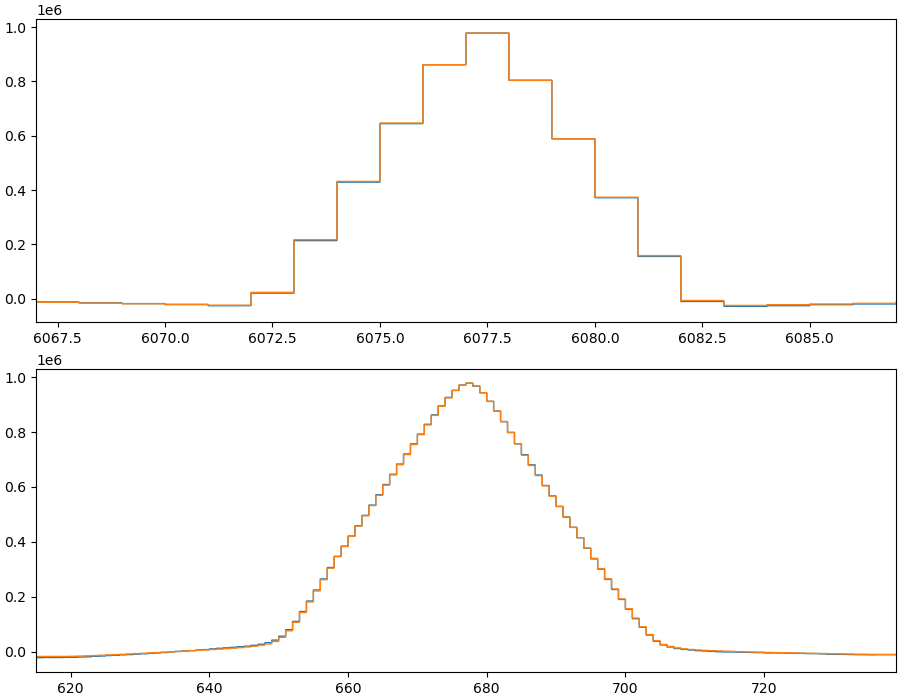

In [28]:
fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(9, 7))
axs[0].set_title('')
axs[0].stairs(skysim[:, peak_p[1]])
axs[0].stairs(skyiros[:, peak_p[1]])

axs[0].set_xlim( (peak_p[0] - 2*xspan , peak_p[0] + 2*xspan))


axs[1].set_title('')
axs[1].stairs(skysim[peak_p[0], :])
axs[1].stairs(skyiros[peak_p[0], :])

axs[1].set_xlim( (peak_p[1] - 2*yspan , peak_p[1] + 2*yspan))

plt.show()

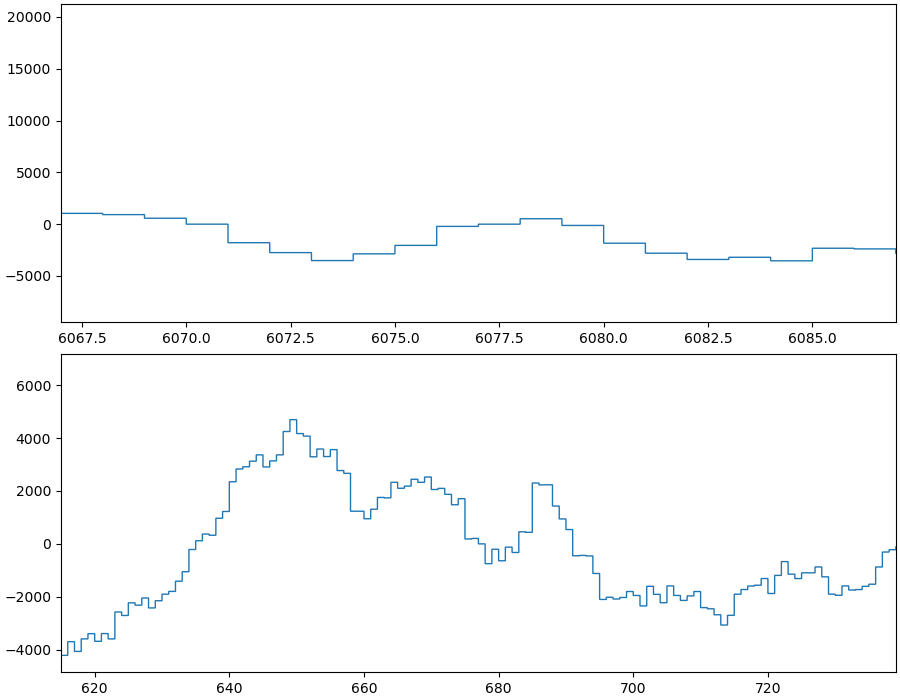

In [29]:
skydiff = skysim - skyiros

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(9, 7))
axs[0].set_title('')
axs[0].stairs(skydiff[:, peak_p[1]])
axs[0].set_xlim( (peak_p[0] - 2*xspan , peak_p[0] + 2*xspan))

axs[1].set_title('')
axs[1].stairs(skydiff[peak_p[0], :])
axs[1].set_xlim( (peak_p[1] - 2*yspan , peak_p[1] + 2*yspan))

plt.show()

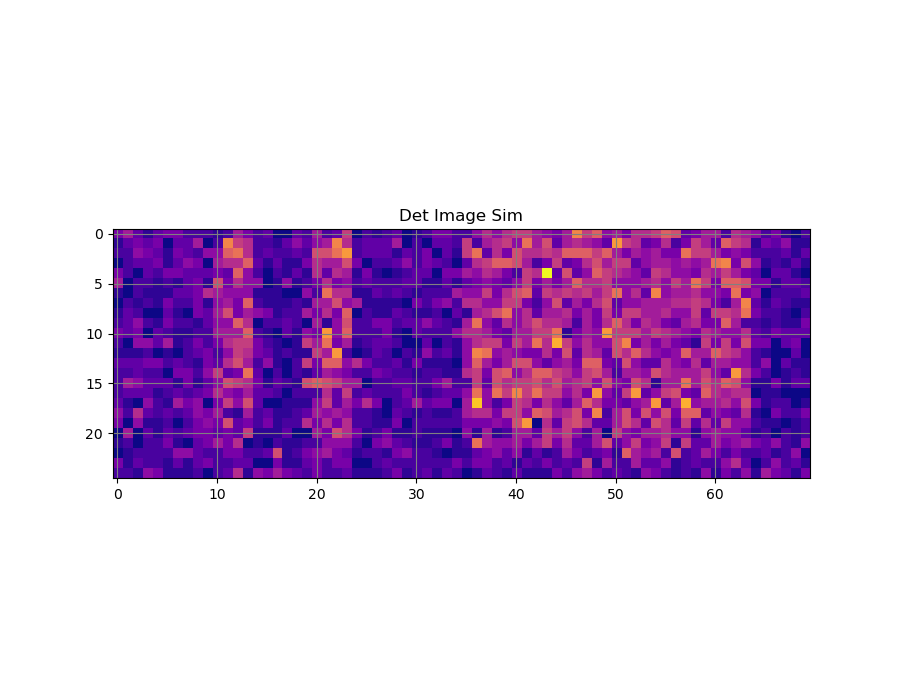

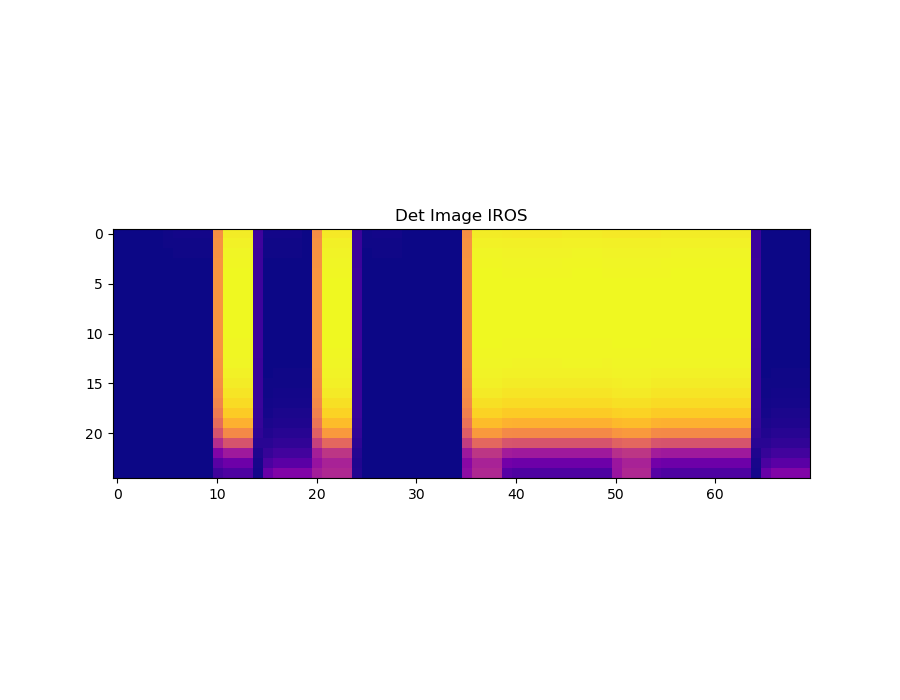

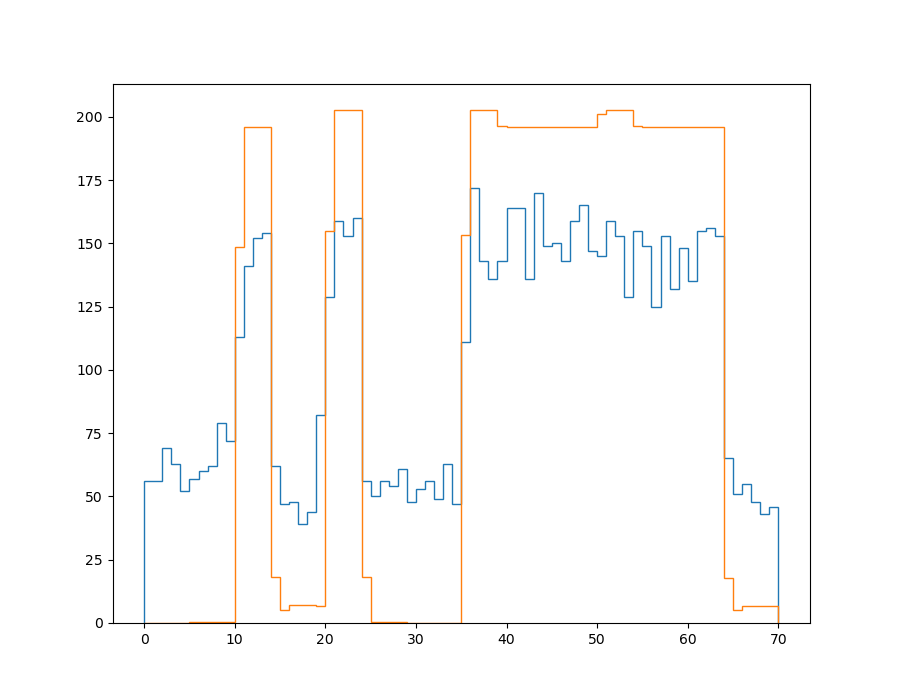

In [18]:
norm = np.sum(detimagesim)/np.sum(detimage_iros)
f = int(up_f_x/5)
appo_sim = detimagesim[1825*f:1895*f, 186:211]
appo_iros = detimage_iros[1825*f:1895*f, 186:211]

'''
plt.figure(figsize=(9, 7))
plt.title("Det Image Sim")
plt.imshow(detimagesim.T, cmap=cm.plasma,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()
'''
plt.figure(figsize=(9, 7))
plt.title("Det Image Sim")
#plt.imshow(appo_sim[164:225, 5:35].T, cmap=cm.plasma,  interpolation='nearest')#, aspect=ELYDIM/ELXDIM) #cam1a
plt.imshow(appo_sim.T, cmap=cm.plasma,  interpolation='nearest')#, aspect=ELYDIM/ELXDIM) #cam1a
plt.grid(which= 'both', color='gray')
#plt.imshow(appo_sim.T[5:31, 12:55], cmap=cm.plasma,  interpolation='nearest')#, aspect=ELYDIM/ELXDIM)#cam1b
plt.show()

plt.figure(figsize=(9, 7))
plt.title("Det Image IROS")
plt.imshow(appo_iros.T, cmap=cm.plasma,  interpolation='nearest')#, aspect=ELYDIM/ELXDIM)#cam1a
#plt.imshow(appo_iros[164:225, 5:35].T, cmap=cm.plasma,  interpolation='nearest')#, aspect=ELYDIM/ELXDIM)#cam1a
#plt.imshow(appo_iros.T[5:31, 12:55], cmap=cm.plasma,  interpolation='nearest')#, aspect=ELYDIM/ELXDIM)#cam1b
plt.show()

'''
plt.figure(figsize=(9, 7))
plt.title("Det Image Diff")
#plt.imshow(appo_sim[164:175, 12:15].T - appo_iros[164:175, 12:15].T * norm, cmap=cm.plasma,  interpolation='nearest', aspect=ELYDIM/ELXDIM)#cam1a
plt.show()
'''
plt.figure(figsize=(9, 7))
norm = appo_sim.T.sum()/appo_iros.T.sum()
plt.stairs(appo_sim.T.sum(axis=0))#, aspect=ELYDIM/ELXDIM)#cam1b
plt.stairs(appo_iros.T.sum(axis=0) * norm)#, aspect=ELYDIM/ELXDIM)#cam1b
plt.show()

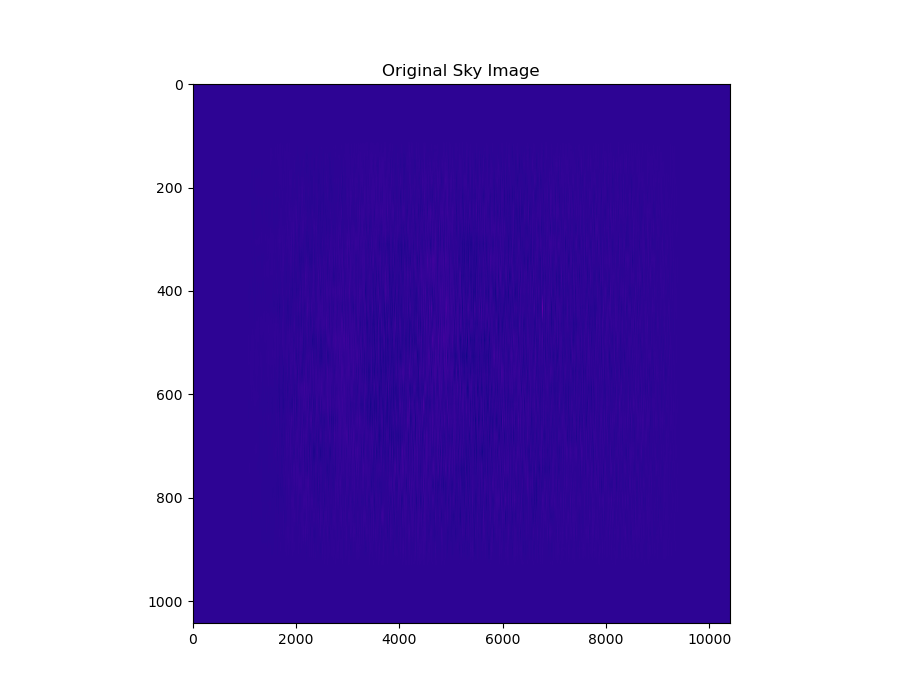

In [19]:
plt.figure(figsize=(9, 7))
plt.title("Original Sky Image")
plt.imshow(skysim.T, cmap=cm.plasma,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()

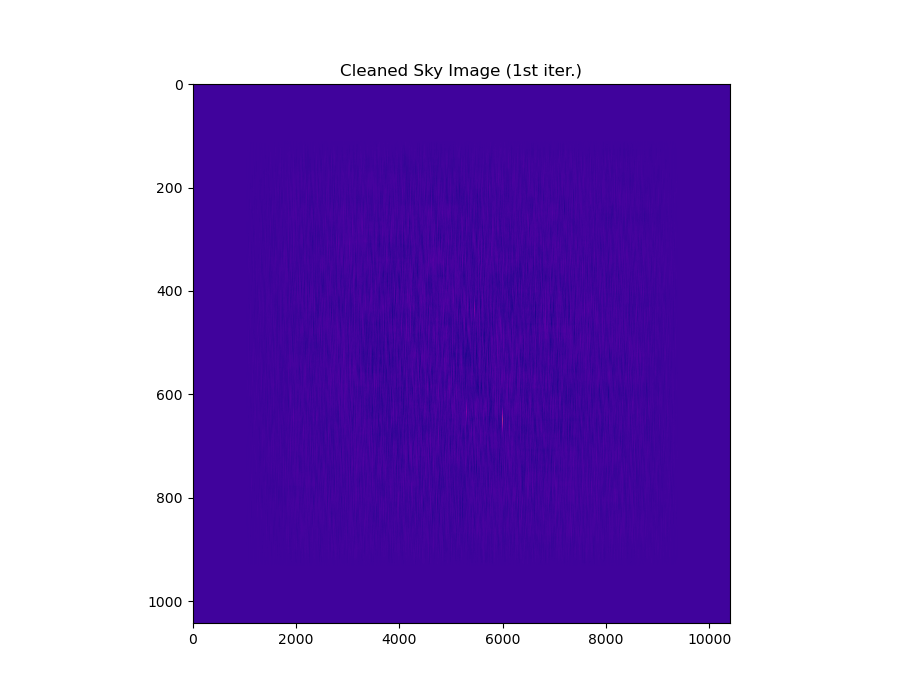

In [20]:
plt.figure(figsize=(9, 7))
plt.title("Cleaned Sky Image (1st iter.)")
plt.imshow(skydiff.T, cmap=cm.plasma,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()

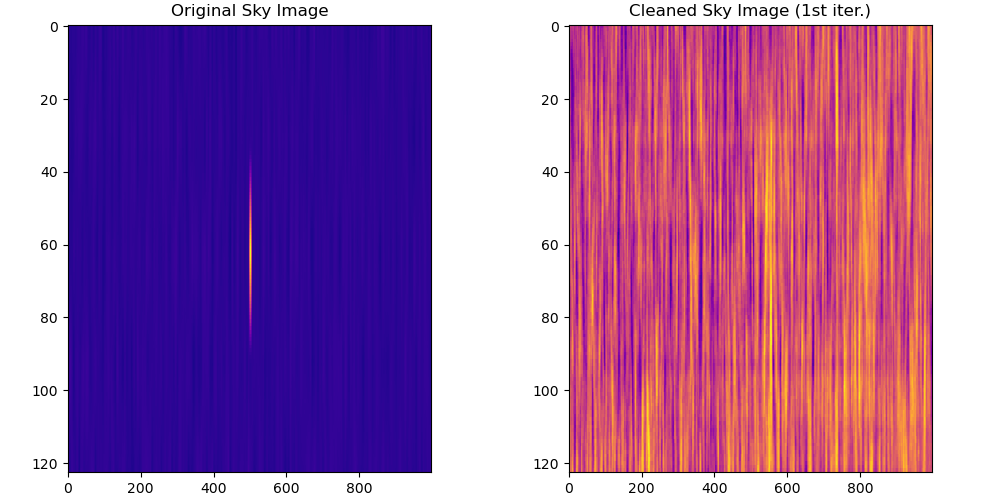

In [21]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))
vmin, vmax = np.min(skysim),np.max(skysim)
axs[0].set_title('Original Sky Image')
axs[0].imshow(skysim[peak_p[0] - 100*xspan:peak_p[0] + 100*xspan - 1 , peak_p[1]-2*yspan: peak_p[1]+2*yspan -1].T, cmap=cm.plasma, vmin=vmin, vmax=vmax, interpolation='nearest', aspect=ELYDIM/ELXDIM)

axs[1].set_title('Cleaned Sky Image (1st iter.)')
axs[1].imshow(skydiff[peak_p[0] - 100*xspan:peak_p[0] + 100*xspan - 1 , peak_p[1]-2*yspan: peak_p[1]+2*yspan -1].T, cmap=cm.plasma,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()